# Writing performant Julia code

## Introducing a toy example

In [1]:
function lap2d!(u, unew)
    M, N = size(u)
    for j in 2:N-1
        for i in 2:M-1
            unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end 
    end
end

lap2d! (generic function with 1 method)

In [2]:
function setup(N=2048, M=2048)
    u = zeros(M, N)
    # set boundary conditions
    u[1,:] = u[end,:] = u[:,1] = u[:,end] .= 2.0
    unew = copy(u);
    return u, unew
end

setup (generic function with 3 methods)

In [3]:
u, unew = setup()

([2.0 2.0 … 2.0 2.0; 2.0 0.0 … 0.0 2.0; … ; 2.0 0.0 … 0.0 2.0; 2.0 2.0 … 2.0 2.0], [2.0 2.0 … 2.0 2.0; 2.0 0.0 … 0.0 2.0; … ; 2.0 0.0 … 0.0 2.0; 2.0 2.0 … 2.0 2.0])

   Resolving package versions...
  No Changes to `~/07_github_proj/julia-for-hpc/Project.toml`
  No Changes to `~/07_github_proj/julia-for-hpc/Manifest.toml`


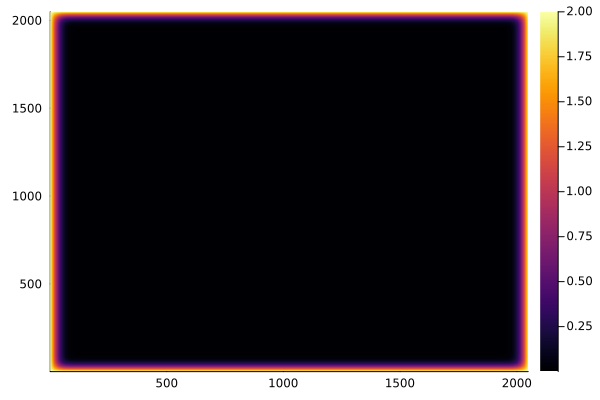

In [4]:
using Pkg
#Pkg.activate()
Pkg.add("Plots")
for i in 1:2000
    lap2d!(u, unew)
    # copy new computed field to old array
    u = copy(unew)
end

using Plots
heatmap(u)

## Benchmarking

In [5]:
#using Pkg
#Pkg.activate()
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/07_github_proj/julia-for-hpc/Project.toml`
  No Changes to `~/07_github_proj/julia-for-hpc/Manifest.toml`


In [6]:
using BenchmarkTools
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 1555 samples with 1 evaluation.
 Range (min … max):  3.118 ms …  3.674 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.142 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.163 ms ± 54.752 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    █▇▃                                                       
  ▃█████▆▆▅▅▄▄▄▄▃▃▃▃▃▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂ ▃
  3.12 ms        Histogram: frequency by time        3.38 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [7]:
bench_results = @benchmark lap2d!(u, unew)
typeof(bench_results)
println(minimum(bench_results.times))

3.122333e6


## Profiling

In [8]:
Pkg.add("Profile")
using Profile

Profile.init(delay=0.1)

Profile.clear() # clear backtraces from earlier runs
@profile lap2d!(u, unew)
Profile.print()

   Resolving package versions...
  No Changes to `~/07_github_proj/julia-for-hpc/Project.toml`
  No Changes to `~/07_github_proj/julia-for-hpc/Manifest.toml`


Overhead ╎ [+additional indent] Count File:Line; Function
 ╎2 @Base/task.jl:514; (::IJulia.var"#15#18")()
 ╎ 2 @IJulia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
 ╎  2 @Base/essentials.jl:816; invokelatest
 ╎   2 @Base/essentials.jl:819; #invokelatest#2
 ╎    2 ...rc/execute_request.jl:67; execute_request(socket::ZMQ.Socke...
 ╎     2 ...c/SoftGlobalScope.jl:65; softscope_include_string(m::Modu...
 ╎    ╎ 2 @Base/loading.jl:1903; include_string(mapexpr::typeof...
 ╎    ╎  2 @Base/boot.jl:370; eval
 ╎    ╎   2 In[1]:5; lap2d!(u::Matrix{Float64}, unew...
 ╎    ╎    1 @Base/array.jl:971; setindex!
1╎    ╎    1 @Base/essentials.jl:14; getindex
Total snapshots: 6. Utilization: 100% across all threads and tasks. Use the `groupby` kwarg to break down by thread and/or task.


In [9]:
Pkg.add("ProfileView")
using ProfileView
@profview lap2d!(u, unew)

   Resolving package versions...
  No Changes to `~/07_github_proj/julia-for-hpc/Project.toml`
  No Changes to `~/07_github_proj/julia-for-hpc/Manifest.toml`


Gtk4.GtkWindowLeaf(accessible-role=GTK_ACCESSIBLE_ROLE_APPLICATION, name="", parent, root, width-request=-1, height-request=-1, visible=true, sensitive=true, can-focus=true, has-focus=false, can-target=true, focus-on-click=true, focusable=false, has-default=false, receives-default=false, cursor, has-tooltip=false, tooltip-markup=nothing, tooltip-text=nothing, opacity=1,000000, overflow=GTK_OVERFLOW_HIDDEN, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, hexpand=false, vexpand=false, hexpand-set=false, vexpand-set=false, scale-factor=2, css-name="window", css-classes, layout-manager, title="Profile  -  15:02:07", resizable=true, modal=false, default-width=800, default-height=600, destroy-with-parent=false, hide-on-close=false, icon-name=nothing, display, decorated=true, deletable=true, transient-for, application, default-widget, focus-widget, child, titlebar, handle-menubar-accel=true, is-active=false, suspended=false, startup-i

## Optimization options

In [10]:
function lap2d!(u, unew)
    M, N = size(u)
    for i in 2:M-1
        for j in 2:N-1
            unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end
    end
end

lap2d! (generic function with 1 method)

In [11]:
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 131 samples with 1 evaluation.
 Range (min … max):  37.994 ms …  41.147 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     38.099 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.196 ms ± 342.887 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▆                                                           
  █████▆▇▃▆█▄▅▇▃▆▄▄▁▁▃▃▁▃▁▁▁▁▁▁▃▁▃▁▁▁▃▁▁▃▃▁▁▁▁▁▁▁▁▁▁▃▁▁▁▃▃▁▁▁▃ ▃
  38 ms           Histogram: frequency by time         39.2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [12]:
function lap2d!(u, unew)
    M, N = size(u)
    for j in 2:N-1
        for i in 2:M-1
            @inbounds unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end 
    end
end

lap2d! (generic function with 1 method)

In [13]:
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 2553 samples with 1 evaluation.
 Range (min … max):  1.918 ms …  2.254 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.952 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.955 ms ± 20.666 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

              ▂▅▄▅▆█▆▆▄▅▄ ▁                                   
  ▂▂▂▃▃▃▄▄▅▇▇██████████████▇▆▅▅▅▃▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂ ▄
  1.92 ms        Histogram: frequency by time        2.03 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [14]:
Pkg.add("StaticArrays")
using StaticArrays
m1 = rand(10,10)
m2 = @SArray rand(10,10)

@btime m1*m1
# 311.808 ns (1 allocation: 896 bytes)

@btime m2*m2
# 99.902 ns (1 allocation: 816 bytes)

   Resolving package versions...
  No Changes to `~/07_github_proj/julia-for-hpc/Project.toml`
  No Changes to `~/07_github_proj/julia-for-hpc/Manifest.toml`


  207.122 ns (1 allocation: 896 bytes)
  79.522 ns (1 allocation: 816 bytes)


10×10 SMatrix{10, 10, Float64, 100} with indices SOneTo(10)×SOneTo(10):
 1.71301  1.64034  2.09213  2.68331  …  2.29709  2.57274  3.21913  2.56208
 2.03003  2.28891  2.72428  3.84022     2.45362  2.95597  3.93481  2.91738
 1.8517   2.22276  2.73431  2.98644     1.88018  1.91996  3.70976  1.80825
 2.30153  1.58004  2.80952  2.65258     2.50231  2.17165  3.59661  2.3815
 1.47751  1.64051  2.76079  2.36319     2.31094  2.00458  3.09564  2.41504
 1.67848  1.60218  2.23152  2.53816  …  1.96358  1.92718  3.31379  1.95302
 2.31772  1.89102  2.56741  2.90706     2.49937  2.29312  3.34182  2.86186
 1.48732  1.78174  2.15189  2.93157     1.85224  2.81851  3.34077  2.00183
 1.90325  2.05654  2.15051  3.74458     2.28418  3.19082  3.70628  2.80623
 2.41887  2.22872  2.83052  3.18401     2.46058  2.17833  3.7962   2.79856